In [1]:
import cv2 as cv
import numpy as np
import copy
from matplotlib import pyplot as plt
from utils import Splitter
import utils
import math

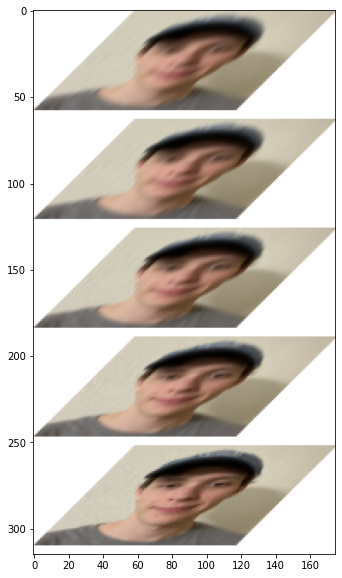

In [2]:
k = math.sqrt(2)
sigma = 1
img = cv.imread("me.PNG", cv.IMREAD_COLOR)
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
#img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
n_octaves = 4

octaves = []
for i in range(n_octaves):
    octave = utils.gen_octave(img, 5)
    img = cv.resize(img, (img.shape[0] // 2, img.shape[0] // 2))
    octaves.append(octave)
plt.figure(figsize=(10,10))
#plt.imshow(utils.stack_imgs(octaves[0]), cmap = "gray")
plt.imshow(utils.stack_imgs(octaves[2]))

In [3]:
DoGs = []
octave = octaves[2]
for i in range(len(octave) - 1):
    sub_img = octave[i + 1] - octave[i]
    DoGs.append(sub_img)

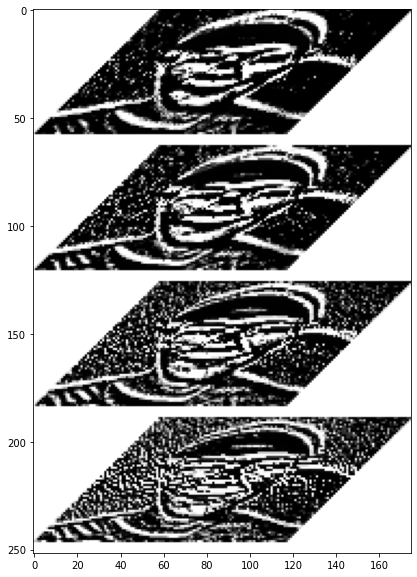

In [4]:
plt.figure(figsize=(10,10))
stacked = utils.stack_imgs(DoGs)
stacked = cv.cvtColor(stacked, cv.COLOR_BGR2GRAY)
plt.imshow(stacked, cmap = "gray")
#plt.imshow(utils.stack_imgs(DoG_octave))

In [5]:
for i, DoG in enumerate(DoGs):
   DoGs[i] = cv.cvtColor(DoG, cv.COLOR_BGR2GRAY)

In [14]:
candidate1_map, candidates1 = utils.extrema_detection(DoGs, 1)
candidate2_map, candidates2 = utils.extrema_detection(DoGs, 2)
candidates = candidates1 + candidates2

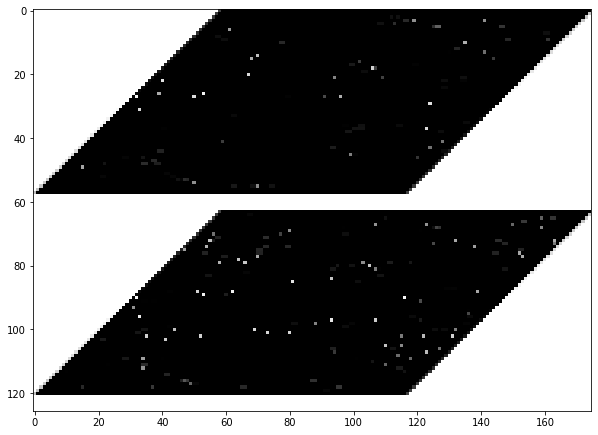

In [15]:
plt.figure(figsize=(10,10))
stacked = utils.stack_imgs([candidate1_map, candidate2_map])
plt.imshow(stacked, cmap = "gray")

In [16]:
def keypoint_inter(DoGs, cands, max_it=5):
    res = []

    for cand in cands:
        (sigma, x, y) = cand

        for i in range(max_it):
            s_prev, s_curr, s_next = DoGs[sigma - 1:sigma + 2]
            neighborhood = np.stack([
                s_prev[y - 1:y + 2, x - 1:x + 2],
                s_curr[y - 1:y + 2, x - 1:x + 2],
                s_next[y - 1:y + 2, x - 1:x + 2],
            ]).astype(np.float32) / 255
            offset, contrast = quad_inter(neighborhood)

def quad_inter(neigh):
    # Compute first deriv (Gradient) in Taylor series on candidate
    dx = (neigh[1, 1, 2] - neigh[1, 1, 0]) / 2
    dy = (neigh[1, 2, 1] - neigh[1, 0, 1]) / 2
    ds = (neigh[2, 1, 1] - neigh[0, 1, 1]) / 2
    grad = np.array([dx, dy, ds])

    # Compute second deriv (Hessian) in Taylor series on candidate
    candidate = neigh[1, 1, 1]
    dxx = neigh[1, 1, 2] - 2 * candidate + neigh[1, 1, 0]
    dyy = neigh[1, 2, 1] - 2 * candidate + neigh[1, 0, 1]
    dss = neigh[2, 1, 1] - 2 * candidate + neigh[0, 1, 1]
    dxy = (neigh[1, 2, 2] - neigh[1, 2, 0] - neigh[1, 0, 2] + neigh[1, 0, 0]) / 4
    dxs = (neigh[2, 1, 2] - neigh[2, 1, 0] - neigh[0, 1, 2] + neigh[0, 1, 0]) / 4
    dys = (neigh[2, 2, 1] - neigh[2, 0, 1] - neigh[0, 2, 1] + neigh[0, 0, 1]) / 4
    hess = np.array([
        [dxx, dxy, dxs], 
        [dxy, dyy, dys],
        [dxs, dys, dss]
    ])

    # Solve for offset and contrast
    z_hat = np.linalg.inv(hess).dot(grad)
    contrast = candidate + grad.T.dot(z_hat) / 2  

    return z_hat, contrast

In [17]:
keypoint_inter(DoGs, candidates)

TypeError: _stack_dispatcher() got an unexpected keyword argument 'dtype'